In [1]:
import h5py
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.structure import atom_select
from structures_store import StructuresStoreDataset, h5_store_structure, h5_load_structure

colors = ['#bf4e30', '#0d3b66', '#0e9595', '#c2c1c2', '#dbad6a']

/home/khaos/miniconda3/envs/pesto/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
uniprots = pd.read_csv("datasets/selected_alphafold_models.csv").query("selected > 0.5")['uniprot'].values

data = {}
with h5py.File("datasets/aggregated_structures_data.h5", 'r') as hf:
    #for uniprot in tqdm(hf.keys()):
    for uniprot in tqdm(uniprots):
        data[uniprot] = h5_load_structure(hf[uniprot])

100%|██████████████████████████████████████| 7464/7464 [00:33<00:00, 224.48it/s]


In [3]:
for uniprot in data:
    entry = data[uniprot]
    break

In [4]:
dfs = pd.DataFrame(entry)
dfs

,afs,annotation,p0,p1,p2,p3,p4,resid,resname,ss,x,y,z
0,67.040001,Modified residue,0.002775,0.000041,0.008363,0.017583,0.004209,1,MET,,-20.885000,-7.085,3.838000
1,89.000000,,0.002556,0.000070,0.009470,0.018736,0.000257,2,ALA,,-19.582001,-3.943,5.574000
2,95.629997,,0.004811,0.000257,0.025719,0.030031,0.000037,3,SER,,-17.378000,-1.779,3.272000
3,98.709999,Beta strand,0.001505,0.000014,0.041666,0.042805,0.000060,4,LYS,,-13.596000,-2.251,3.606000
4,98.879997,Beta strand,0.003695,0.000100,0.028141,0.068452,0.000048,5,ARG,E,-11.538000,0.689,4.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,98.480003,,0.997042,0.000875,0.053104,0.083734,0.000031,185,LEU,G,-10.209000,3.275,-16.399000
185,98.139999,,0.998075,0.002806,0.045710,0.055657,0.000017,186,VAL,T,-9.351000,2.656,-20.127001
186,97.970001,,0.997633,0.002621,0.070507,0.130161,0.000045,187,LEU,,-6.023000,1.049,-19.145000
187,97.540001,,0.995830,0.030220,0.105583,0.151944,0.000159,188,LYS,,-3.851000,-0.724,-21.711000


## Residue interface prevalence

In [5]:
# parameters
afs_thr = 70.0
p_thr = 0.8

# extract predictions
p_dict = {}
for uniprot in tqdm(data):
    entry = data[uniprot]
    for i in range(len(entry['resname'])):
        if entry['afs'][i] > afs_thr:
            resname = entry['resname'][i]
            if resname in p_dict:
                for j in range(5):
                    p_dict[resname][j].append(entry['p{}'.format(j)][i])
            else:
                p_dict[resname] = [[entry['p{}'.format(j)][i]] for j in range(5)]

# extract prediction ratios per residue
ratios = []
for i in range(5):
    pi_dict = {resname:p_dict[resname][i] for resname in p_dict}
    ratio = {}
    for resname in pi_dict:
        ratio[resname] = np.mean(np.array(pi_dict[resname]) > p_thr)
    ratios.append(ratio)

100%|█████████████████████████████████████| 7464/7464 [00:05<00:00, 1338.79it/s]


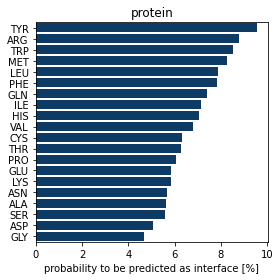

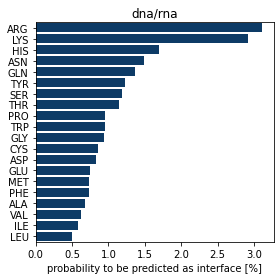

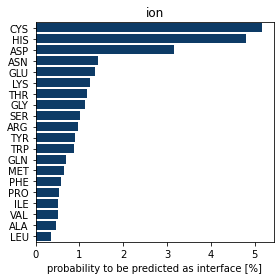

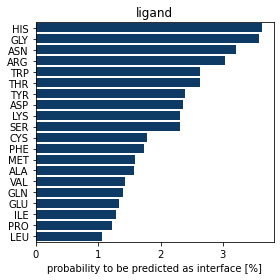

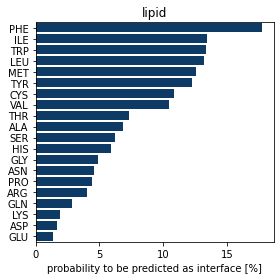

In [6]:
# plots
labels = ["protein", "dna/rna", "ion", "ligand", "lipid"]
for i in range(5):
    int_ratio = pd.Series(ratios[i]).sort_values(ascending=True).to_dict()
    x = np.array(list(int_ratio))
    y = np.array(list(int_ratio.values()))
    t = np.arange(x.shape[0])

    plt.figure(figsize=(4,4))
    plt.barh(t, y*1e2, color=colors[1])
    plt.ylim(-0.5, len(t)-0.5)
    plt.yticks(t, x)
    plt.title(labels[i])
    plt.xlabel("probability to be predicted as interface [%]")
    plt.tight_layout()
    plt.savefig("results/residue_interface_p{}_ratio.png".format(i), dpi=300)
    plt.savefig("results/residue_interface_p{}_ratio.svg".format(i))
    plt.show()

* Use uniprot annotation and alphafold structures to train model for more interfaces

### Residue activity

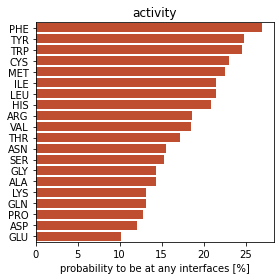

In [7]:
# parameters
p_thr = 0.8

# extract global interface prediction ratio
global_ratio = {}
for resname in p_dict:
    global_ratio[resname] = np.mean(np.max(np.array(p_dict[resname]), axis=0) > p_thr)
    
# plot
int_ratio = pd.Series(global_ratio).sort_values(ascending=True).to_dict()
x = np.array(list(int_ratio))
y = np.array(list(int_ratio.values()))
t = np.arange(x.shape[0])

plt.figure(figsize=(4,4))
plt.barh(t, y*1e2, color=colors[0])
plt.ylim(-0.5, len(t)-0.5)
plt.yticks(t, x)
plt.xlabel("probability to be at any interfaces [%]")
plt.title("activity")
plt.tight_layout()
plt.savefig("results/residue_interface_global_ratio.png", dpi=300)
plt.savefig("results/residue_interface_global_ratio.svg")
plt.show()

* water interface model to quantify hydrophobicity

## Interface composition
* positive: ARG, HIS, LYS
* negative: ASP, GLU
* polar: SER, THR, ASN, GLN
* nonpolar: ALA, VAL, ILE, LEU, MET, PHE, TYR, TRP
* special: CYS, GLY, PRO

In [8]:
compo_types = {
    'charged': ['ARG', 'HIS', 'LYS', 'ASP', 'GLU'],
    'polar': ['SER', 'THR', 'ASN', 'GLN'],
    'hydrophobic': ['ALA', 'VAL', 'ILE', 'LEU', 'MET', 'PHE', 'TYR'],
    'special': ['CYS', 'GLY', 'PRO'],
}

In [9]:
# parameters
afs_thr = 70.0
p_thr = 0.8

# extract predictions
compo_dict = {key:[0 for i in range(5)] for key in compo_types}
for uniprot in tqdm(data):
    entry = data[uniprot]
    for i in range(len(entry['resname'])):
        if entry['afs'][i] > afs_thr:
            resname = entry['resname'][i]
            for key in compo_types:
                if resname in compo_types[key]:
                    for k in range(5):
                        if entry['p{}'.format(k)][i] > p_thr:
                            compo_dict[key][k] += 1

100%|██████████████████████████████████████| 7464/7464 [00:22<00:00, 325.51it/s]


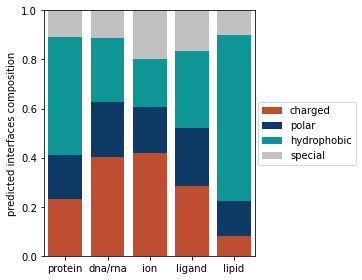

In [10]:
C = pd.DataFrame(compo_dict).values
H = C / np.sum(C, axis=1).reshape(-1,1)
Hs = np.concatenate([np.zeros((H.shape[0],1)),np.cumsum(H, axis=1)], axis=1)
t = np.arange(H.shape[0])
x = ["protein", "dna/rna", "ion", "ligand", "lipid"]

# plot
plt.figure()
for i in range(H.shape[1]):
    plt.bar(t, H[:,i], bottom=Hs[:,i], label=list(compo_types)[i], color=colors[i])
plt.xticks(np.linspace(0.0, t.shape[0]-1.0, t.shape[0]), x)
plt.xlim(-0.5, t.shape[0]-0.5)
plt.ylim(0.0, 1.0)
plt.ylabel('predicted interfaces composition')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.savefig("results/interfaces_composition.png", dpi=300)
plt.savefig("results/interfaces_composition.svg")
plt.show()

## Secondary structure

In [11]:
# parameters
afs_thr = 70.0
p_thr = 0.8
ss_dict = {
    'H' : "helix",
    'B' : "strand",
    'E' : "strand",
    'G' : "helix",
    'I' : "helix",
    'T' : "coil",
    'S' : "coil",
    ' ' : "coil"
}

# extract predictions
p_dict = {}
for uniprot in tqdm(data):
    entry = data[uniprot]
    for i in range(len(entry['ss'])):
        if entry['afs'][i] > afs_thr:
            #ss = entry['ss'][i]
            ss = ss_dict[entry['ss'][i]]
            if ss in p_dict:
                for j in range(5):
                    p_dict[ss][j].append(entry['p{}'.format(j)][i])
            else:
                p_dict[ss] = [[entry['p{}'.format(j)][i]] for j in range(5)]

# extract prediction ratios per residue
ratios = []
for i in range(5):
    pi_dict = {resname:p_dict[resname][i] for resname in p_dict}
    ratio = {}
    for resname in pi_dict:
        ratio[resname] = np.mean(np.array(pi_dict[resname]) > p_thr)
    ratios.append(ratio)

100%|█████████████████████████████████████| 7464/7464 [00:05<00:00, 1398.71it/s]


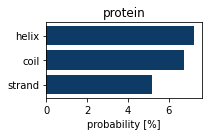

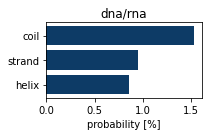

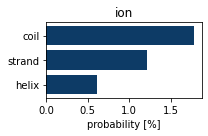

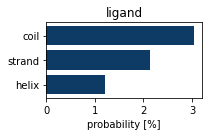

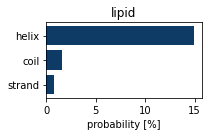

In [12]:
# plots
labels = ["protein", "dna/rna", "ion", "ligand", "lipid"]
ss_dict = {
    'H' : "Alpha helix",
    'B' : "Residue in isolated beta-bridge",
    'E' : "Extended strand, participates in beta ladder",
    'G' : "3-helix (3/10 helix)",
    'I' : "5 helix (pi helix)",
    'T' : "hydrogen bonded turn",
    'S' : "bend",
    ' ' : "Loops and irregular elements"
}

for i in range(5):
    int_ratio = pd.Series(ratios[i]).sort_values(ascending=True).to_dict()
    x = np.array(list(int_ratio))
    y = np.array(list(int_ratio.values()))
    t = np.arange(x.shape[0])

    plt.figure(figsize=(3,2))
    plt.barh(t, y*1e2, color=colors[1])
    #plt.xticks(t, [ss_dict[k] for k in x], rotation=90)
    plt.yticks(t, x)
    plt.xlabel('probability [%]')
    plt.title(labels[i])
    plt.tight_layout()
    #plt.savefig("results/secondary_structure_interface_p{}_ratio.png".format(i), dpi=150)
    #plt.savefig("results/secondary_structure_interface_p{}_ratio.svg".format(i))
    plt.show()

## Uniprot regions

In [13]:
# parameter
afs_thr = 70.0

# aggregate predictions by annotation
p_notes = {}
for uniprot in tqdm(data):
    entry = data[uniprot]
    for i in range(len(entry['annotation'])):
        if entry['afs'][i] > afs_thr:
            notes = entry['annotation'][i].split(':')
            for note in notes:
                if note in p_notes:
                    p_notes[note].append([entry['p{}'.format(j)][i] for j in range(5)])
                else:
                    p_notes[note] = [[entry['p{}'.format(j)][i] for j in range(5)]]

100%|██████████████████████████████████████| 7464/7464 [00:17<00:00, 431.88it/s]


### Region coverage

In [17]:
# parameters
p_thr = 0.8
sel_tags = [
    'Active site',
    'Binding site',
    'Calcium binding',
    'DNA binding',
    'Glycosylation',
    'Intramembrane',
    'Lipidation',
    'Metal binding',
    'Nucleotide binding',
    'Site',
    'Topological domain',
    'Transmembrane',
    'Zinc finger'
]

H = []
for tag in sel_tags:
    P = np.array(p_notes[tag])
    
    c = np.sum(P > p_thr, axis=0)
    h = c / P.shape[0]
    H.append(h)
    
H = np.array(H)

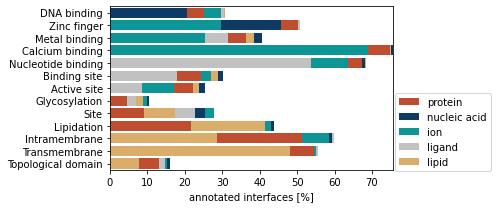

,protein,nucleic acid,ion,ligand,lipid
DNA binding,4.6,20.5,4.5,0.7,0.2
Zinc finger,4.3,16.2,29.6,0.6,0.2
Metal binding,4.9,2.1,25.3,6.2,2.2
Calcium binding,5.9,0.3,68.9,0.1,0.3
Nucleotide binding,3.7,0.7,9.9,53.8,0.3
Binding site,6.5,1.2,2.6,17.8,1.9
Active site,5.0,1.5,8.5,8.7,1.7
Glycosylation,4.5,0.5,1.1,2.4,1.9
Site,9.2,2.7,2.4,5.4,8.1
Lipidation,21.6,0.6,1.8,0.0,19.8


In [19]:
#from theme import colors
colors = ['#bf4e30', '#0d3b66', '#0e9595', '#c2c1c2', '#dbad6a']
labels = ["protein", "nucleic acid", "ion", "ligand", "lipid"]
ordered_features = [
    'DNA binding',
    'Zinc finger',
    'Metal binding',
    'Calcium binding',
    'Nucleotide binding',
    'Binding site',
    'Active site',
    'Glycosylation',
    'Site',
    'Lipidation',
    'Intramembrane',
    'Transmembrane',
    'Topological domain',
]
ids = np.array([np.where(t == np.array(sel_tags))[0].item() for t in ordered_features])[::-1]

Ho = np.stack([H[ids,i] for i in range(5)], axis=1)
iO = np.argsort(Ho, axis=1)[:,::-1]
So = np.sort(Ho, axis=1)[:,::-1]
Zo = np.cumsum(So, axis=1) - So

t = np.arange(Ho.shape[0])
x = np.array(ordered_features)

plt.figure(figsize=(7,3))
for i in range(5):
    plt.barh(t, Ho[:,i]*1e2, left=Zo[np.where(iO == i)[0], np.where(iO == i)[1]]*1e2, label=labels[i], color=colors[i])

plt.ylim(-0.5, len(t)-0.5)
plt.xlim(0.0, np.max(np.sum(Ho, axis=1))*1e2)
plt.legend(bbox_to_anchor=(0.99, 0.5))
plt.yticks(t, x[::-1])
plt.xlabel("annotated interfaces [%]")
plt.tight_layout()
plt.savefig("results/annotation_coverage_all.png", dpi=300)
plt.savefig("results/annotation_coverage_all.svg")
plt.show()

dfs = pd.DataFrame(np.round(1e2*Ho[::-1],1), index=ordered_features, columns=labels)
dfs.to_csv("results/annotation_coverage_all.csv")
dfs